<a href="https://colab.research.google.com/github/sysbio-unam/practicas-computacionales-Python/blob/main/algoritmo_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Algoritmo de Gillespie

Nombre: Biología de sistemas UNAM

Fecha: diciembre 2021

In [24]:
# importar librerías
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

In [25]:
# parámetros del modelo
p1 = 2
k2 = 0.1

In [27]:
# función para calcular las velociades de generación y degradación 
def velocidades(GFP):
    return [p1, k2 * GFP] 

In [28]:
def gillespieGFp(GFP0, tend):
    # lista para guardar los valores de GFP en el tiempo
    GFP = [GFP0]
    # lista para guardar los tiempos en los que ocurren los eventos
    t = [0]
    # usamos un ciclo while porque no sabemos cuantas interaciones vamos a necesitar
    while t[-1] < tend:
        # tomamos el último valor de GFP
        GFP_actual = GFP[-1]
        # calculamos la suma de las velocidades de generación y degradación
        suma_vel = sum(velocidades(GFP_actual))
        # muestreamos el tiempo que vamos a avanzar de una distribución exponencial 
        tau = np.random.exponential(scale=1/suma_vel)
        # damos el paso en el tiempo 
        t.append(t[-1] + tau)

        # generamos un número aleatorio entre 0 y 1 para determinar el evento que ocurrirá
        rand = random.uniform(0,1)
        # evento de producción
        if rand * suma_vel > 0 and rand * suma_vel <= p1:
            GFP.append(GFP[-1] + 1)

        # evento de degradación
        else:
            GFP.append(GFP[-1] - 1)
    return [t, GFP]

In [37]:
out = gillespieGFp(0, 100)

Text(0, 0.5, 'GFP')

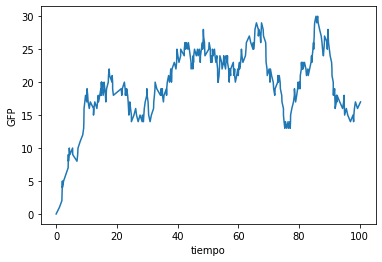

In [39]:
plt.plot(out[0], out[1])
plt.xlabel("tiempo")
plt.ylabel("GFP")